In [175]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.green_crab_movingAvg import greenCrabMonthNormalizedMoving
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from LipschitzPPO import LipschitzPPO
from LipschitzRecurrentPPO import LipschitzRecurrentPPO
import os
import plotnine
from plotnine import ggplot, geom_point, aes, geom_line, facet_wrap, geom_path
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [176]:
# Interpolate policy

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

#@ray.remote
def GaussianProcessPolicy(policy_df, length_scale=1, noise_level=0.1):
  """
  policy_df.columns = [X, Y, Z, act_x, act_y]
                    -> action (act_x, act_y) taken at point (X, Y, Z)
  """
  predictors = policy_df[["obs0", "obs1"]].to_numpy()
  targets = policy_df[["act0", "act1", 'act2']].to_numpy()
  # X_scaler = StandardScaler().fit(predictors)
  # y_scaler = StandardScaler().fit(targets)
  # X_scaled = X_scaler.transform(predictors)
  # y_scaled = y_scaler.transform(targets)
  kernel = (
    1.0 * RBF(length_scale = length_scale) 
    + WhiteKernel(noise_level=noise_level)
    )
  print("Fitting Gaussian Process...")
  gpp = (
    GaussianProcessRegressor(kernel=kernel, random_state=0)
    .fit(predictors, targets)
    )
  print("Done fitting Gaussian Process...")
  # return gpp, X_scaler, y_scaler
  return gpp

In [177]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':False,
    # "curriculum": True
}
env = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64


In [178]:
# recurrentPPOAgent = RecurrentPPO.load("varianceRatio0.3/RecurrentPPO_gcmenorm_256_1_varR0.3", device="cpu")
tqcAgent = TQC.load(f"varRatio0.3_new/TQC_gcmenorm", device="cpu")
ppoData = simulator(env = env, agent = tqcAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)

<Axes: xlabel='t'>

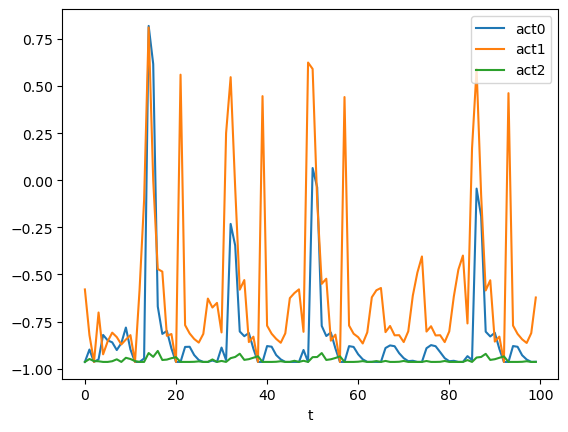

In [179]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

In [ ]:
df = ppoDataDF
plt.scatter(x=df[df.rep == 0]['obs0'], y=df[df.rep == 0]['act0'], label='act0 vs obs0', alpha=0.7)

In [7]:
df = ppoDataDF.drop(columns=['t', 'rew', 'rep'])

In [8]:
gpp= GaussianProcessPolicy(df, length_scale=1, noise_level=1)

Fitting Gaussian Process...
Done fitting Gaussian Process...


In [86]:
def generate_gpp_episodes(gpp, env, reps=50):
      """ gpp is a gaussian process regression of the RL policy """
      df_list = []
      state_list = []
      for rep in range(reps):
        episode_reward = 0
        observation, _ = env.reset()
        population = env.observation['crabs']
        state = env.state
        for t in range(env.Tmax):
          # pop_sacled = X_scaler.transform(np.array([population]))
            
          action = gpp.predict([population])[0]
          # action = y_scaler.inverse_transform([action])[0]
          #print(f"pop = {population}")
          #print(f"action = {action}")
          esc_x = population[0] * (1 - action[0])
          esc_y = population[1] * (1 - action[1])
          
          df_list.append(np.append([t, rep, action[0], action[1], action[2], episode_reward, esc_x], population))
          state_list.append([t, rep, state])
        
          observation, reward, terminated, done, info = env.step(action)
          population = env.observation['crabs']
          state = env.state
          
          episode_reward += reward
          if terminated:
            break
      cols =['t','rep', 'act0', 'act1', 'act2', 'rew', 'esc_x', 'obs0', 'obs1']
      df = pd.DataFrame(df_list, columns = cols)
      state_df = pd.DataFrame(state_list, columns= ['t', 'rep', 'state'])
      df = pd.merge(df, state_df, on=['t','rep'], how='inner')
      return df, state_df

In [87]:
DATAPATH = '.'
ITERATIONS = 1000
print("Finished fitting GP!")
gpp_df, state_df= generate_gpp_episodes(gpp, env, reps=5)
gpp_df.to_csv(os.path.join(DATAPATH,f"ppo{ITERATIONS}_GPP.csv.xz"), index = False)

Finished fitting GP!


In [60]:
gpp_df['log_act0'] = np.log(gpp_df['act0']+1)

/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log


In [64]:
gpp_df['act0/act1'] = (gpp_df['act0'] + 1) / (gpp_df['act1'] + 1)

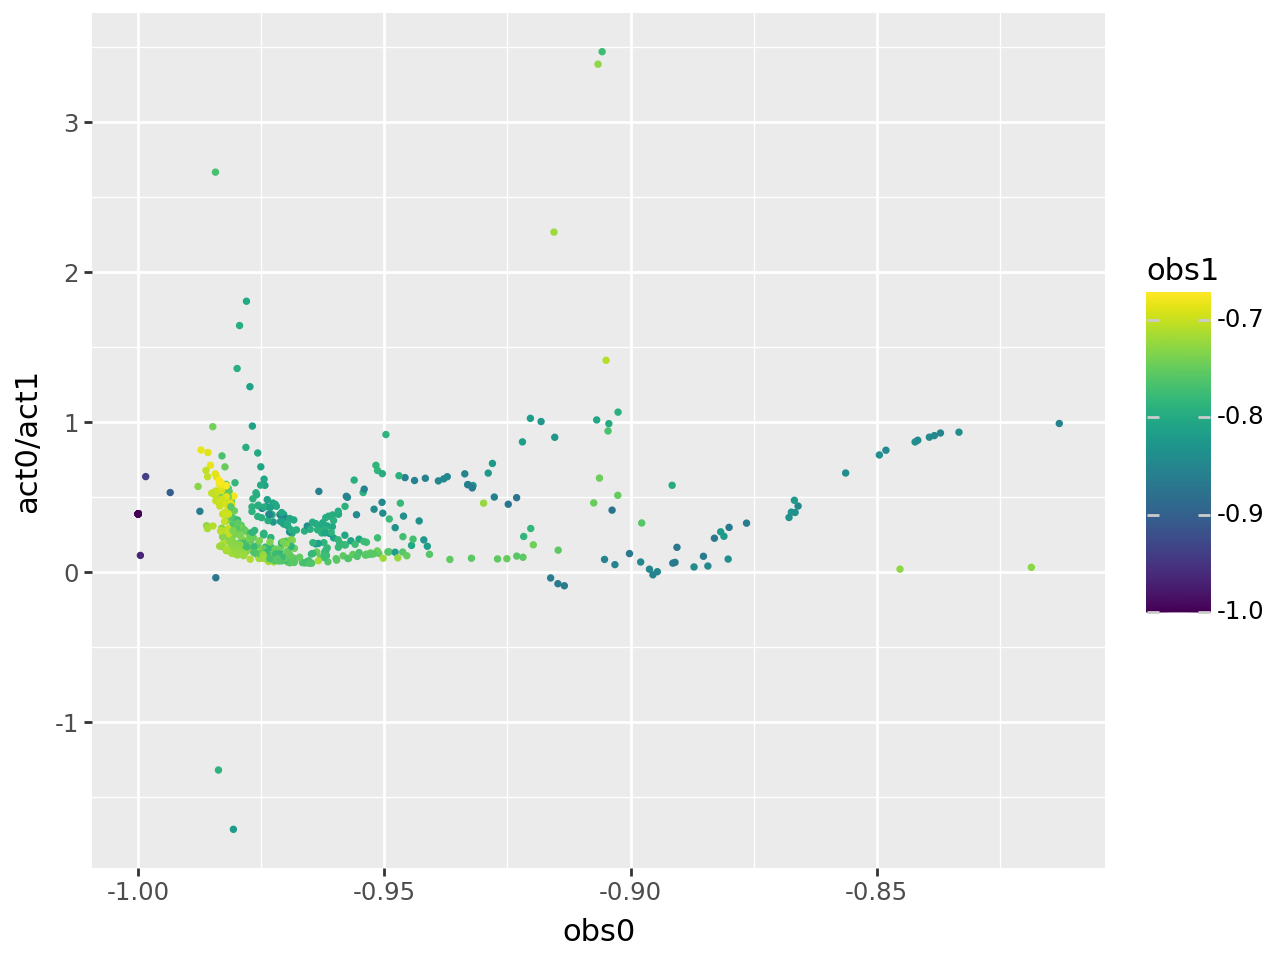

In [65]:
ggplot(gpp_df, aes("obs0", 'act0/act1', color='obs1')) + geom_point(shape=".")

In [ ]:
ggplot(gpp_df, aes("obs0", 'act0/act1', color='obs1')) + geom_point(shape=".")

In [190]:
def state_heatmap(df, rep=0):
    state_rep = df[df['rep']==0]
    state_rep = state_rep.loc[1:, ['t','state']]
    # state_rep['state'] = np.log(state_rep['state'], axis=0)
    size_df = pd.DataFrame(state_rep['state'].tolist())
    size_df.columns = [f'size_{i}' for i in range(1, size_df.shape[1]+1)]
    state_rep =  pd.concat([state_rep.drop(columns=['state']), size_df], axis=1)
    # prepare heatmap
    df_melted = state_rep.melt(id_vars='t', value_name='abundance', var_name='size')
    df_melted['size'] = df_melted['size'].str.extract(r'(\d+)').astype(int)
    heatmap_data = df_melted.pivot(index='size', columns='t', values='abundance')
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Abundance'})
    plt.xlabel('Time')
    plt.ylabel('Size Class')
    plt.title('Heatmap of State Abundance Over Time by Size')
    plt.tight_layout()
    plt.show()

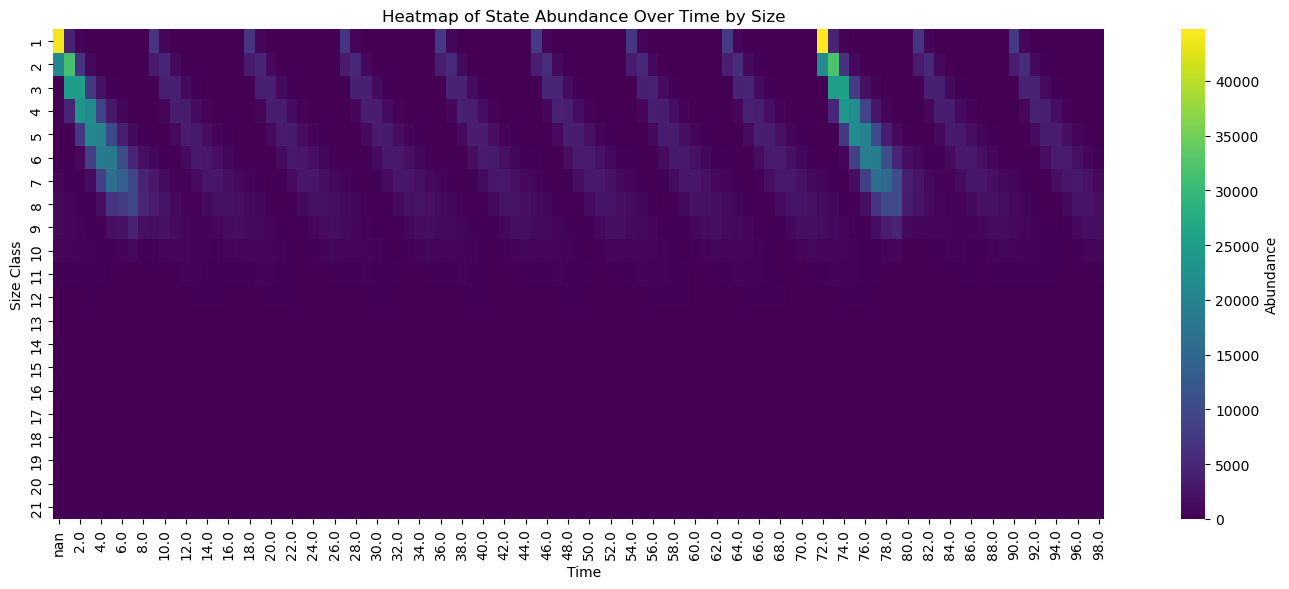

In [191]:
state_heatmap(state_df, rep=0)

In [164]:
def action_heatmap(gpp_df, rep=0): 
    gpp_df_rep  = gpp_df[gpp_df['rep']==rep]
    action_df = gpp_df_rep.loc[:, ['t', 'act0', 'act1', 'act2']]
    action_df = action_df.melt(id_vars='t', value_name='action', var_name='action_type')
    action_df['action_type'] = action_df['action_type'].str.extract(r'(\d+)').astype(int)
    heatmap_data = action_df.pivot(index='action_type', columns='t', values='action')
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Abundance'})
    plt.xlabel('Time')
    plt.ylabel('action_type')
    plt.title('Heatmap of action Over Time by action_typex')
    plt.tight_layout()
    plt.show()

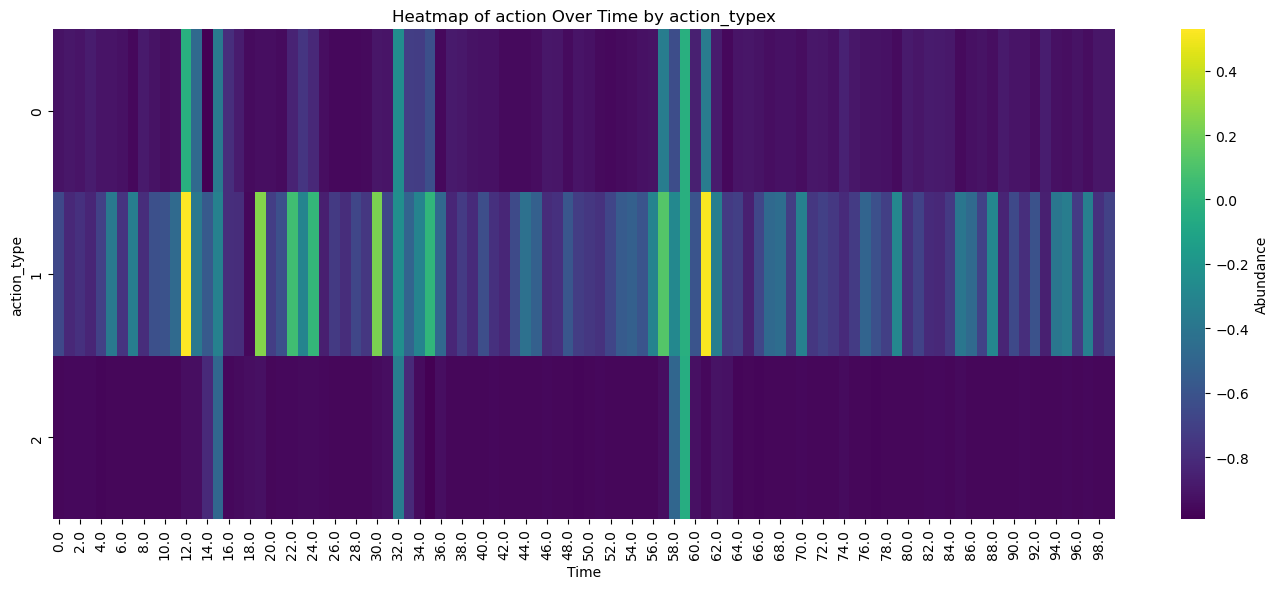

In [167]:
action_heatmap(gpp_df, rep=3)